# EPS 109 Final Project: The Strongest Pokemon

George Liu

EPS 109 Fall 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.gridspec import GridSpec

---------------------------------

## Data Preparation

Creates the following tables for use in the rest of the notebook:
* showdex: table of Gen 7 Pokemon Showdown Random Battle movesets with some non-vanilla Pokemon removed; indexed by name of Pokemon
* pokedex: table of Pokemon up to Gen 7 with information about their various stats and features; indexed by the name of the Pokemon
* movedex: table of Pokemon moves with information about their Type, Category, Power, etc.; indexed by the name of the move

-----------------------------
### Pokemon Data
From https://www.kaggle.com/datasets/rounakbanik/pokemon

In [2]:
pokemon_info_table = pd.read_csv('pokemon_kaggle_thrugen7.csv')
pokedex = pokemon_info_table.set_index('name')
pokedex.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'percentage_male', 'pokedex_number', 'sp_attack',
       'sp_defense', 'speed', 'type1', 'type2', 'weight_kg', 'generation',
       'is_legendary'],
      dtype='object')

In [3]:
pokedex.tail(3)

abilities  against_bug  against_dark  against_dragon  \
name                                                                   
Guzzlord  ['Beast Boost']         2.00           0.5             2.0   
Necrozma  ['Prism Armor']         2.00           2.0             1.0   
Magearna   ['Soul-Heart']         0.25           0.5             0.0   

          against_electric  against_fairy  against_fight  against_fire  \
name                                                                     
Guzzlord               0.5            4.0            2.0           0.5   
Necrozma               1.0            1.0            0.5           1.0   
Magearna               1.0            0.5            1.0           2.0   

          against_flying  against_ghost  ...  percentage_male  pokedex_number  \
name                                     ...                                    
Guzzlord             1.0            0.5  ...              NaN             799   
Necrozma             1.0            2.0  ...              NaN             800   
Magearna             0.5            1.0  ...              NaN             801   

          sp_attack  sp_defense  speed    type1   type2  weight_kg  \
name                                                                 
Guzzlord         97          53     43     dark  dragon      888.0   
Necrozma        127          89     79  psychic     NaN      230.0   
Magearna        130         115     65    steel   fairy       80.5   

          generation  is_legendary  
name                                
Guzzlord           7             1  
Necrozma           7             1  
Magearna           7             1  

[3 rows x 40 columns]

-----------------------------------------
### Pokemon Showdown Collection
From https://github.com/pkmn/randbats/tree/main/data

In [4]:
showdown_table = pd.read_json('gen7randombattlejson.txt').transpose()
print(len(showdown_table))
# showdown_table.head()

578


In [5]:
# eliminates regional variants ("-Alola"), megas ("-Mega"), forms ("-Rainy", "-Black", "-Wash", "-10%"), etc. 
# those would make this difficult to match up with the vanilla pokedex
# sadly, also eliminates some legitimate Pokemon like Ho-Oh and Kommo-o, but oh well
# showdex = showdown_table[np.logical_not(showdown_table.index.str.contains('-'))]

# more generally: keep only Pokemon present in the available Kaggle pokedex data
# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values
showdex = showdown_table.loc[showdown_table.index.isin(pokedex.index)]
if 'Unown' in showdex.index:
    showdex = showdex.drop('Unown', axis=0)     # Unown only knows Hidden Power, which is problematic for the rest of the code
print(len(showdex))
showdex.head(3)

438


level       abilities  \
Abomasnow    88  [Snow Warning]   
Absol        88     [Justified]   
Accelgor     86   [Sticky Hold]   

                                                       items  \
Abomasnow    [Assault Vest, Focus Sash, Leftovers, Life Orb]   
Absol      [Choice Band, Choice Scarf, Focus Sash, Life Orb]   
Accelgor     [Choice Specs, Focus Sash, Leftovers, Life Orb]   

                                                       moves         evs  \
Abomasnow  [Blizzard, Earthquake, Focus Punch, Giga Drain...  {'atk': 0}   
Absol      [Knock Off, Play Rough, Pursuit, Sucker Punch,...         NaN   
Accelgor   [Bug Buzz, Encore, Energy Ball, Focus Blast, H...  {'atk': 0}   

                  ivs  
Abomasnow  {'atk': 0}  
Absol             NaN  
Accelgor   {'atk': 0}

______________________________________________
### Move Data
Scraped from https://bulbapedia.bulbagarden.net/wiki/List_of_moves

In [6]:
movedex = pd.read_csv('move_data.csv')
movedex = movedex.set_index('Name')
movedex = movedex.fillna(0)
movedex.head(3)

#      Type  Category    PP  Power  Accuracy Gen
Name                                                         
Pound        1    Normal  Physical  35.0   40.0      1.00   I
Karate Chop  2  Fighting  Physical  25.0   50.0      1.00   I
Double Slap  3    Normal  Physical  10.0   15.0      0.85   I

______________________________________________
## Classes and Functions

### Utilities

In [7]:
typings = movedex['Type'].unique()
# print(typings)
against_typing_dict = dict([(t, 'against_' + str.lower(t)) for t in typings])
against_typing_dict['Fighting'] = 'against_fight'    # Manual fix for this stupid difference: Fighting --> against_fight
# print(against_typing_dict)

def against(typing):
    '''
    Converts a "Type" (like appears in movedex) input text into 
    "against_type" output text(like appears in pokedex data).
    '''
    return against_typing_dict[typing]

against('Fairy')

'against_fairy'

In [8]:
# For nice type colors
# https://gist.github.com/apaleslimghost/0d25ec801ca4fc43317bcff298af43c3
# types in all lowercase-- matches with pokedex data

color_file = pd.read_csv('type_colors.txt', sep=':', header=None, names=['Type', 'Hex Code'])
color_file['Hex Code'] = color_file['Hex Code'].str.extract(r"(#[A-Z0-9]+)")
color_file = color_file.set_index('Type')

typing_color_dict = color_file['Hex Code'].to_dict()

def typing_colors(type1, type2):
    c1 = typing_color_dict[type1]
    c2 = typing_color_dict[type2] if pd.notnull(type2) else c1
    return (c1, c2)

typing_colors('fairy', np.nan)

('#D685AD', '#D685AD')

### Pokemon Class

In [9]:
class Pokemon:
    def __init__(self, name, level=None, x=None, y=None, id_num=None):
        self.name = name
        self.data = pokedex.loc[name, :]
        
        # self.moveset = showdex.loc[name, 'moves']
        self.moveset = [move for move in showdex.loc[name, 'moves'] if (move in movedex.index)] # and movedex.loc[move, 'Category'] != 'Status'
        # only allow moves we have data for, e.g. "Hidden Power Fire" is an unpleasant formatting from showdown
        # that doesn't match "Hidden Power" from Bulbapedia and we'll just have to throw it out
        # also throw out status moves because we're hoping for damage output--UPDATE: doesn't work b/c some pokemon have only status moves
        
        if level == None:
            self.level = 100
        elif level == 'randbats':
            self.level = showdex.loc[name, 'level']
        else:
            self.level = level
        
        # https://pokemon.fandom.com/wiki/Statistics#:~:text=Advertisement-,Formula,Level)%20%2B%205)%20x%20Nature
        stat_names = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']
        base_stats = self.data[stat_names]
        IVs = np.ones(6) * 31
        EVs = np.ones(6) * 84
        nature = np.ones(5)
        stat_values = np.floor(0.01 * (2 * base_stats + IVs + np.floor(0.25 * EVs)) * self.level)
        stat_values[0] += self.level + 10
        stat_values[1:] = nature * (stat_values[1:] + 5)
        self.stats = pd.Series(data=stat_values, index=stat_names, dtype=int)
        
        self.hp = self.stats['hp']
        self.wins = 0
        
        self.x = x        
        self.y = y
        self.id_num = id_num
        #self.battlefield = battlefield
        self.alive = True
        
        self.display_colors = typing_colors(self.data['type1'], self.data['type2'])
    
    def __str__(self):
        return self.name
    
    
    def display_info(self):
        print(self.name)
        print(f'Level {self.level}')
        print(f'Stats: \n{self.stats}')
        print(f'Moves: {self.moveset}')
        print(f'Wins: {self.wins}')
    
    
    def attack(self, opponent, random=False):
        """Chooses a move to attack the opponent with to maximize damage (or at random)"""
        if random:
            r = np.random.rand()
            choice_index = np.floor(r * len(self.moveset))
            move = self.moveset[choice_index]
            move_data = movedex.loc[move, :]
            damage = self.calc_damage_helper(opponent, move_data)
            return damage, move
        
        best_damage = 0
        best_move = None
        for move in self.moveset:
            move_data = movedex.loc[move, :]
            damage = self.calc_damage_helper(opponent, move_data, low_roll=True, acc_check=False)
            if damage >= best_damage:
                best_damage = damage
                best_move = move
                
        move_data = movedex.loc[best_move, :]
        actual_damage = self.calc_damage_helper(opponent, move_data, low_roll=False, acc_check=False)   # ADJUST HERE: choose whether accuracy impacts outcome
        return actual_damage, best_move
    
    
    def calc_damage_helper(self, opponent, move_data, low_roll=False, acc_check=False):
        if acc_check:
            r = np.random.rand()
            if r > move_data['Accuracy']:
                return 0
        
        # https://bulbapedia.bulbagarden.net/wiki/Damage#Generation_V_onward
        if move_data['Category'] == "Physical":
            base_damage = ((2 * self.level / 5 + 2) * move_data['Power'] * self.stats['attack'] / opponent.stats['defense']) / 50 + 2
        elif move_data['Category'] == "Special":
            base_damage = ((2 * self.level / 5 + 2) * move_data['Power'] * self.stats['sp_attack'] / opponent.stats['sp_defense']) / 50 + 2
        else:
            base_damage = 0

        random_value = np.random.randint(85, 100) / 100 if not low_roll else 0.85
        # random is a random factor. Namely, it is recognized as a multiplication from a random integer between 85 and 100, inclusive, then divided by 100. Decimals are rounded down to the nearest integer.
        stab = 1.5 if (move_data['Type'] == self.data['type1'] or move_data['Type'] == self.data['type2']) else 1
        type_matchup = opponent.data[against(move_data['Type'])]

        damage = base_damage * random_value * stab * type_matchup
        return int(damage)
        

    def propose_move(self):
        # https://pokemon.fandom.com/wiki/Statistics#:~:text=The%20average%20base%20Speed%20for,reverted%20to%20the%20Speed%20stat.
        # The average base speed stat for fully evolved pokemon is 78. 
        # We will suppose that a Pokemon below this speed stat has a chance to either move or not move on a turn,
        # with the chance of moving proportional to its base speed stat.
        # Above average, a move is required.
        prob_moving = min(self.data['speed'] / 78, 1.0)
        r = np.random.rand()
        if r > prob_moving:
            return np.array([0, 0])
        
        r =  np.random.rand()
        if r < 0.25:
            return np.array([1, 0])
        elif r < 0.5:
            return np.array([0, 1])
        elif r < 0.75:
            return np.array([-1, 0])
        else:
            return np.array([0, -1])
    
#     def take_damage(self, dmg):
#         ### unneeded ###
#         self.hp -= dmg
#         if self.hp < 0:
#             return
    
#     def restore(self):
#         ### unneeded ###
#         self.hp = self.stats['hp']

    def faint(self):
        self.alive = False
        
    def add_win(self):
        self.wins = self.wins + 1

#### Testing Pokemon class functionality

In [10]:
# a = Pokemon('Xatu', level='randbats')
# b = Pokemon('Bronzong', level='randbats')
# a.display_info()
# b.display_info()

In [11]:
# movedex.loc['Heat Wave',:]

In [12]:
# a.calc_damage_helper(b, movedex.loc['Heat Wave',:], low_roll=True)

In [13]:
# pokedex.loc['Gourgeist', :]

In [14]:
# for species in showdex.index.to_series():
#     p = Pokemon(species)
#     p.display_info()
#     print(p.attack(a))

### Battlefield manager

In [15]:
class Battlefield:
    def __init__(self, x_size, y_size):
        self.x_size = x_size
        self.y_size = y_size
        
        self.poke_count = 0
        # self.id_count = 0     #we'll not allow re-adding pokemon later so this won't be necessary
        self.poke_alive = []     # will be ordered by decreasing speed after finalize_roster()
        self.grid = np.zeros([self.x_size, self.y_size])
        self.id_lookup = {}    # ID --> pokemon, indexed starting from 1, in order of being added

        self.initial_roster = []
        self.initial_poke_count = 0
        self.initial_analytics = pd.Series([], dtype='float64')
        self.initial_typings = pd.Series([], dtype='float64')
        
        self.turn_number = 0
        self.turn_commentary = []
        self.event_commentary = ''
        self.turn_KOs = []
        
        self.log_commentary = []
        
        self.attacks_used = []
        self.winning_attacks_used = []
        
        self.fig = plt.figure(constrained_layout=False, figsize=(15,9))
        
    ### SETUP ###
    def setup(self, pokemon_roster, writer=None):
        for poke_name in pokemon_roster:
            x, y = self.poke_count // self.x_size, self.poke_count % self.x_size   # fill arena from left to right, bottom to top
            p = Pokemon(poke_name, x=x, y=y)
            self.add_poke(p)
        self.finalize_roster()
        
        self.display()
        if writer:
            plt.draw()
            plt.pause(0.01)
            writer.grab_frame()
        
        return
    
        
    def add_poke(self, pokemon):
        # must be used before finalize_roster
        self.poke_count += 1
        self.poke_alive.append(pokemon)
        self.grid[pokemon.x, pokemon.y] = self.poke_count
        
        self.id_lookup[self.poke_count] = pokemon
        pokemon.id_num = self.poke_count
        return


    def finalize_roster(self):
        self.poke_alive = sorted(self.poke_alive, reverse=True, key=lambda p: p.stats['speed'])
        self.initial_roster = list(self.poke_alive)
        self.initial_poke_count = self.poke_count
        self.initial_analytics = self.compile_survivor_analytics()
        self.initial_typings = self.compile_survivor_typings()
        return
    
    
    ### SIMULATE ###
    def run_simulation(self, survivor_threshold=1, turn_threshold=1000, writer=None, display_per_pokemon=False):
        while self.poke_count > survivor_threshold and self.turn_number < turn_threshold:
            self.turn_number += 1
            self.turn_commentary = []
            self.turn_KOs = []
            
            self.take_turns(display_per_pokemon=display_per_pokemon, writer=writer)
            self.resolve_turn_KOs()
            
            self.log_commentary.append(self.turn_commentary)
            
            self.display()
            if writer:
                plt.draw()
                plt.pause(0.01)
                writer.grab_frame()
        return
    
    
    def take_turns(self, display_per_pokemon=False, writer=None):
        if display_per_pokemon:
            self.display()
            if writer:
                plt.draw()
                plt.pause(0.01)
                writer.grab_frame()
        
        for i in range(self.poke_count):
            p = self.poke_alive[i]
            
            if p in self.turn_KOs:     # the Pokemon was already sniped by someone earlier this turn. it can no longer take its own turn
                continue;              # it's set up this way only because it's bad practice to update a python list as you're going through it
            
            #print(f"COMPUTING MOVE FOR {p}")
            
            current_position = np.array([p.x, p.y])
            proposed_move = p.propose_move()
            proposed_position = self.periodic(current_position + proposed_move)
            
            #print(proposed_position)
            if proposed_move[0] == 0 and proposed_move[1] == 0:
                continue;
            elif self.grid[tuple(proposed_position)] == 0:  # or whatever the empty square id_num is
                self.grid[tuple(current_position)] = 0
                self.grid[tuple(proposed_position)] = p.id_num
                p.x, p.y = proposed_position[0], proposed_position[1]
                continue;
            else: 
                opponent_id_num = self.grid[tuple(proposed_position)]
                opponent = self.id_lookup[opponent_id_num]
                successful_attack = self.decide_battle(p, opponent) # commentary and KO already handled
                if successful_attack: 
                    self.grid[tuple(current_position)] = 0     # p makes a successful advance and vacates its own square
                    self.grid[tuple(proposed_position)] = p.id_num  # replace defending opponent with p
                    p.x, p.y = proposed_position[0], proposed_position[1]    # update p's position
                else:
                    self.grid[tuple(current_position)] = 0     # remove p from the board, it lost the attack
                continue;
        # for every pokemon
        # propose move
        # decide battle if necessary and KO pokemon if necessary
        # update move
    
    
    def periodic(self,position):
        return np.mod(position, np.array([self.x_size, self.y_size]))
    
    
    def decide_battle(self, attacker, defender, log_attacks_used=True):
        """Returns true if the attacker wins the fight, as well as performing the necessary update actions (besides movement)."""
        a_dmg, a_move = attacker.attack(defender)
        if log_attacks_used: 
            self.attacks_used.append(a_move)
        if a_dmg >= defender.stats['hp']:     # attacker is faster and snipes the defender before they get a chance
            self.event_commentary = f'{attacker} ambushes {defender} using {a_move}. ' # gets the jump on
            self.turn_commentary.append(self.event_commentary)
            self.KO_poke(defender)
            attacker.add_win()
            if log_attacks_used: 
                self.winning_attacks_used.append(a_move)
            return True
        
        b_dmg, b_move = defender.attack(attacker)
        if log_attacks_used:
            self.attacks_used.append(b_move)
        if a_dmg > b_dmg:    # attacker does more damage than the defender in one move
            self.event_commentary = f'{attacker} defeats {defender} using {a_move}. '
            self.turn_commentary.append(self.event_commentary)
            self.KO_poke(defender)
            attacker.add_win()
            if log_attacks_used: 
                self.winning_attacks_used.append(a_move)
            return True
        else:     # defender does more or equal damage than the attacker in one move
            self.event_commentary = f'{defender} fends off {attacker} using {b_move}. '   # stops in its tracks, holds against
            self.turn_commentary.append(self.event_commentary)
            self.KO_poke(attacker)
            defender.add_win()
            if log_attacks_used: 
                self.winning_attacks_used.append(b_move)
            return False
    
    
    def KO_poke(self, pokemon):
        self.turn_KOs.append(pokemon)
        pokemon.faint()
        
        
    def resolve_turn_KOs(self):
        for pokemon in self.turn_KOs:
            self.poke_count -= 1
            self.poke_alive.remove(pokemon)
            self.id_lookup.pop(pokemon.id_num)
        self.turn_KOs = []

        
    def display(self):
        # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html#sphx-glr-gallery-subplots-axes-and-figures-gridspec-multicolumn-py
        
        # big_grid = GridSpec(5, 3, wspace = 0.1, hspace = 0.1)
        
        fig = self.fig
        
        fig.clear()
        
        gs = GridSpec(3, 5, figure=fig, wspace=0.2)
        ax1 = fig.add_subplot(gs[:, 0:3])  # main display
        ax2 = fig.add_subplot(gs[0, 3])   # alive (by speed)
        ax4 = fig.add_subplot(gs[1, 3])   
        ax3 = fig.add_subplot(gs[0, 4])   # most KOs
        ax5 = fig.add_subplot(gs[1, 4])
        ax6 = fig.add_subplot(gs[2, 3:])

        for i, ax in enumerate(fig.axes):
            # ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
            ax.tick_params(labelbottom=False, labelleft=False)
            if i:
                ax.tick_params(bottom=False, left=False)
        
        ### main arena display ###
        ax1.set_xlim(-0.1, self.x_size - 0.9)
        ax1.set_xticks(np.arange(0, self.x_size))
        ax1.set_ylim(-0.1, self.y_size - 0.9)
        ax1.set_yticks(np.arange(0, self.x_size))
        for p in self.poke_alive:
            m = 'D' if p.data['is_legendary'] else 'o'
            c1, c2 = p.display_colors
            ax1.plot(p.x, p.y, marker=m, ms=12, mfc = c2, mec = c1, mew=3)
            ax1.annotate(p.name + '\n', (p.x, p.y), ha='center')
        t = ax1.set_title(f'Battlefield (Turn {self.turn_number})', weight='heavy', fontsize=14)
        t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white')) # https://stackoverflow.com/questions/23696898/adjusting-text-background-transparency
                

        if len(self.turn_commentary) > 2:
            ax1.set_xlabel(self.turn_commentary[0] +f'[{len(self.turn_commentary) - 2} more] \n'+ self.turn_commentary[-1])
        else:
            sentences = ''
            for i in range(len(self.turn_commentary)):
                sentences = sentences + self.turn_commentary[i]
            ax1.set_xlabel(sentences)
        
        
        ax2.set_title('Fastest Alive:', weight='heavy', fontsize=14)
        ax2.text(0.075, 0.95, self.text_list_fastest(9), fontsize = 12, va='top')
        
        ax3.set_title('Most Wins:', weight='heavy', fontsize=14)
        ax3.text(0.075, 0.95, self.text_list_mostKOs(9), fontsize = 12, va='top')
        
        ax4.set_title('Popular Attacks:', weight='heavy', fontsize=14)
        ax4.text(0.075, 0.95, self.text_list_movesused(9), fontsize = 12, va='top')
        
        ax5.set_title('Survivor Analytics:', weight='heavy', fontsize=14)
        ax5.text(0.075, 0.95, self.text_survivoranalytics(), fontsize = 12, va='top')
        
        ax6.set_title('Type Distribution:', weight='heavy', fontsize=14)
        #ax6.text(0.075, 0.95, self.compile_survivor_typings(), fontsize = 12, va='top')
        type_dist = self.compile_survivor_typings()
        
        df2 = type_dist.to_frame()
        df1 = pd.Series(data=typing_color_dict).to_frame()
        df = df1.merge(df2, how='left', left_index=True, right_index=True).fillna(0)
        df.columns = ['color', 'frequency']
        
        ax6.bar(x=df.index.tolist(), height=df['frequency'], color=df['color'])
        ax6.tick_params(labelbottom=True, labelleft=True, bottom=True, left=True, labelrotation=45)
        # ax6.set_ylim(0, np.max(self.initial_typings))
        #ax6.set_xticklabels(df.index.tolist(), rotation=45, ha='right')

        print(*self.turn_commentary)
        
        
    def text_list_fastest(self, n):
        speed_text = ''
        for i in range(min([n, self.poke_count])):
            poke = self.poke_alive[i]
            speed = poke.stats['speed']
            speed_text = speed_text + f'{i+1}. {poke} - {speed} \n'
        return speed_text
    
    
    def text_list_mostKOs(self, n):
        by_KOs = self.initial_roster.copy()
        by_KOs.sort(reverse=True, key = lambda p: p.wins)
        kos_text = ''
        for i in range(min([n, self.initial_poke_count])):
            poke = by_KOs[i]
            condition = ' [X]' if not poke.alive else ''
            kos_text = kos_text + f'{i + 1}. {poke}{condition} - {poke.wins} \n'
        return kos_text
    
    
    def text_list_movesused(self, n, winning=True):
        # https://stackoverflow.com/questions/10741346/frequency-counts-for-unique-values-in-a-numpy-array
        x = self.winning_attacks_used if winning else self.attacks_used
        unique, counts = np.unique(x, return_counts=True)
        best_moves = sorted(zip(unique, counts), reverse=True, key=lambda m: m[1])
        
        moves_text = ''
        for i in range(min([n, len(best_moves)])):
            move, freq = best_moves[i]
            moves_text = moves_text + f'{i + 1}. {move} - {freq} \n'
        return moves_text
    
    
    def text_survivoranalytics(self):
        ## Insert code here ##
        # legendaries
        # average stats
        # typing bar chart
        
        names = ['Count', 'Legendaries', 'Avg HP', 'Avg Atk', 'Avg Def', 'Avg SAtk', 'Avg SDef', 'Avg Spd', 'Avg BST']
        analytics = self.compile_survivor_analytics()
        
        analytics_text = ''
        for i in range(len(names)):
            analytics_text = analytics_text + f'{names[i]}: {int(self.initial_analytics[i])} → {int(analytics[i])} \n'
        
        return analytics_text
    

#     def simple_display(self):
#         # big_grid = plt.GridSpec(5, 3, wspace = 0.3, hspace = 0.3)
        
#         ### main arena display ###
#         plt.figure(figsize=(9,9))
#         plt.xlim(-0.1, self.x_size - 0.9)
#         plt.ylim(-0.1, self.y_size - 0.9)
#         plt.xticks([])
#         plt.yticks([])
#         for p in self.poke_alive:
#             m = 'D' if p.data['is_legendary'] else 'o'
#             c1, c2 = p.display_colors
#             plt.plot(p.x, p.y, marker=m, ms=10, mfc = c2, mec = c1, mew=2.5)
#             plt.annotate(p.name, (p.x, p.y))
#         # print(self.turn_commentary)
    
    
    def compile_survivor_analytics(self):
        # ['Count', 'Legendaries', 'Avg hp', 'Avg attack', 'Avg defense', 'Avg sp_attack', 'Avg sp_defense', 'Avg speed', 'Avg BST']
        
        array_alive_ids = pd.Series(self.id_lookup.keys()) # [p.id_num for p in self.poke_alive])
        num_alive = self.poke_count
        num_legendary_alive = np.sum(array_alive_ids.apply(lambda x: self.id_lookup[x].data['is_legendary']))
        avg_stats = np.mean(array_alive_ids.apply(lambda x: self.id_lookup[x].stats), axis=0).tolist()
        avg_bst = np.mean(array_alive_ids.apply(lambda x: np.sum(self.id_lookup[x].data[['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']])), axis=0)
        wanted_info = [num_alive, num_legendary_alive] + avg_stats + [avg_bst]
        return wanted_info
    
    def compile_survivor_typings(self):
        typings = []
        for p in self.poke_alive:
            typings.append(p.data['type1'])
            typings.append(p.data['type2'] if pd.notnull(p.data['type2']) else p.data['type1'])
        typing_counts = pd.Series(typings).value_counts() / 2
        
        return typing_counts
        

------------------------------
## Simulations

### Test

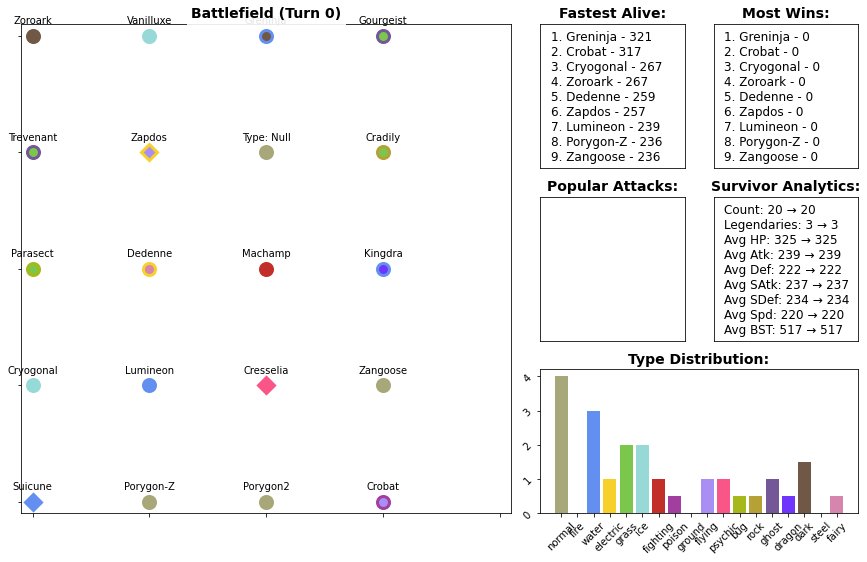

In [16]:
np.random.seed(42)   #42 on 5x5 battlefield with 20 pokemon -- if change to 21, vanilluxe dies faster #44

arena = Battlefield(5,5)
arena.setup(showdex.sample(20).index)

In [17]:
arena.poke_alive[0].name

'Greninja'

In [18]:
arena.run_simulation(turn_threshold=15)

Porygon2 fends off Greninja using Discharge.  Porygon2 fends off Crobat using Ice Beam.  Cryogonal defeats Parasect using Ice Beam.  Suicune fends off Zoroark using Hydro Pump.  Machamp fends off Dedenne using Stone Edge.  Zapdos defeats Type: Null using Heat Wave.  Porygon-Z defeats Porygon2 using Thunderbolt.  Zangoose defeats Cresselia using Knock Off.  Machamp fends off Kingdra using Close Combat.  Machamp defeats Zapdos using Stone Edge. 
Vanilluxe defeats Cryogonal using Explosion. 
Porygon-Z defeats Gourgeist using Ice Beam.  Zangoose defeats Cradily using Close Combat. 

Porygon-Z defeats Trevenant using Ice Beam.  Suicune defeats Zangoose using Hydro Pump. 
Suicune fends off Lumineon using Hydro Pump. 


Machamp defeats Porygon-Z using Close Combat. 


Vanilluxe defeats Suicune using Explosion. 





### Official big simulation

In [19]:
%matplotlib qt

from matplotlib.animation import FFMpegWriter     # new

In [20]:
np.random.seed(42)   #42  #44

arena = Battlefield(21,21)

metadata = dict(title='Pokemon battle royale', artist='Matplotlib',comment='seed 42')
writer = FFMpegWriter(fps=2, metadata=metadata,bitrate=200000)
with writer.saving(arena.fig, "pokemonarena42.mp4", dpi=200):     # new
    arena.setup(showdex.sample(438).index, writer=writer)
    arena.run_simulation(turn_threshold=100, writer=writer)


Deoxys defeats Swanna using Psycho Boost.  Ninjask defeats Hypno using Leech Life.  Pheromosa defeats Minun using High Jump Kick.  Yveltal fends off Electrode using Focus Blast.  Alakazam defeats Haxorus using Focus Blast.  Aerodactyl defeats Politoed using Double-Edge.  Accelgor defeats Gumshoos using Focus Blast.  Garchomp fends off Sceptile using Fire Blast.  Buzzwole fends off Beedrill using Stone Edge.  Mewtwo defeats Hydreigon using Ice Beam.  Houndoom fends off Manectric using Fire Blast.  Lopunny defeats Ferrothorn using High Jump Kick.  Octillery fends off Greninja using Energy Ball.  Gengar defeats Tapu Lele using Sludge Wave.  Jolteon defeats Venomoth using Thunderbolt.  Reshiram fends off Tapu Koko using Blue Flare.  Meloetta defeats Pheromosa using Psyshock.  Shaymin defeats Jumpluff using Air Slash.  Drapion fends off Talonflame using Aqua Tail.  Darkrai defeats Granbull using Sludge Bomb.  Mienshao fends off Swellow using Stone Edge.  Weavile defeats Salamence using Ici

Aerodactyl defeats Typhlosion using Stone Edge.  Gengar defeats Magnezone using Focus Blast.  Golem fends off Tornadus using Explosion.  Minior defeats Vespiquen using Power Gem.  Zebstrika defeats Suicune using Wild Charge.  Dodrio fends off Ambipom using Jump Kick.  Mewtwo fends off Floatzel using Psystrike.  Eelektross fends off Lucario using Superpower.  Diancie defeats Lanturn using Diamond Storm.  Tauros defeats Armaldo using Rock Slide.  Darkrai fends off Archeops using Focus Blast.  Trevenant fends off Virizion using Shadow Claw.  Galvantula defeats Dodrio using Thunder.  Terrakion defeats Chandelure using Stone Edge.  Starmie fends off Cryogonal using Hydro Pump.  Garbodor fends off Zoroark using Gunk Shot.  Charizard fends off Scyther using Fire Blast.  Lunala fends off Mienshao using Moonblast.  Steelix fends off Dedenne using Earthquake.  Volcarona ambushes Cloyster using Giga Drain.  Palkia defeats Yveltal using Draco Meteor.  Oranguru fends off Staraptor using Thunderbolt

Lopunny defeats Steelix using High Jump Kick.  Manaphy defeats Dragalge using Psychic. 
Reshiram fends off Thundurus using Stone Edge.  Heracross defeats Manaphy using Megahorn.  Samurott defeats Snorlax using Sacred Sword.  Omastar fends off Weezing using Earth Power. 
Hitmonchan defeats Ursaring using Drain Punch. 
Swampert defeats Volcanion using Earthquake. 

Deoxys defeats Omastar using Superpower.  Latias fends off Hawlucha using Psychic. 
Carracosta fends off Arbok using Earthquake.  Tapu Bulu fends off Sandslash using Wood Hammer. 
Solgaleo defeats Deoxys using Flare Blitz. 
Metagross defeats Palkia using Explosion.  Cofagrigus fends off Solgaleo using Shadow Ball. 
Latias defeats Rayquaza using Draco Meteor.  Groudon defeats Giratina using Dragon Claw. 



Hitmonchan defeats Darkrai using Drain Punch. 
Metagross fends off Florges using Explosion. 
Spiritomb fends off Crobat using Psychic. 


Gallade defeats Carracosta using Close Combat.  Metagross fends off Xerneas using Expl

In [25]:
# np.random.seed(42)   #42  #44

# arena = Battlefield(21,21)

# metadata = dict(title='Pokemon battle royale', artist='Matplotlib',comment='seed 42')
# writer = FFMpegWriter(fps=10, metadata=metadata,bitrate=200000)
# with writer.saving(arena.fig, "pokemonarena42_perturn.mp4", dpi=200):     # new
#     arena.setup(showdex.sample(438).index, writer=writer)
#     arena.run_simulation(turn_threshold=100, writer=writer, display_per_pokemon=True)

In [22]:
val = 43

np.random.seed(val)   #42  #44

arena = Battlefield(21,21)

metadata = dict(title='Pokemon battle royale', artist='Matplotlib',comment=f'seed {val}')
writer = FFMpegWriter(fps=2, metadata=metadata,bitrate=200000)
with writer.saving(arena.fig, f"pokemonarena{val}.mp4", dpi=200):     # new
    arena.setup(showdex.sample(438).index, writer=writer)
    arena.run_simulation(turn_threshold=100, writer=writer)


Deoxys defeats Scyther using Ice Beam.  Ninjask defeats Virizion using Aerial Ace.  Machamp fends off Pheromosa using Stone Edge.  Alakazam defeats Leafeon using Focus Blast.  Hariyama fends off Electrode using Close Combat.  Aerodactyl defeats Delcatty using Double-Edge.  Accelgor defeats Stantler using Focus Blast.  Toucannon fends off Sceptile using Beak Blast.  Audino fends off Beedrill using Double-Edge.  Mewtwo ambushes Fearow using Ice Beam.  Lopunny defeats Guzzlord using High Jump Kick.  Manectric defeats Ditto using Overheat.  Greninja ambushes Wormadam using Gunk Shot.  Emboar fends off Crobat using Head Smash.  Gengar defeats Mienshao using Focus Blast.  Lycanroc fends off Jolteon using Drill Run.  Dialga fends off Tapu Koko using Fire Blast.  Luxray fends off Meloetta using Crunch.  Shaymin defeats Shuckle using Seed Flare.  Talonflame defeats Ribombee using Flare Blitz.  Azelf fends off Weavile using Explosion.  Zangoose fends off Swellow using Close Combat.  Floatzel fe

Volcarona fends off Deoxys using Bug Buzz.  Alakazam ambushes Mamoswine using Focus Blast.  Aerodactyl defeats Roserade using Double-Edge.  Gengar ambushes Darkrai using Focus Blast.  Drampa fends off Salazzle using Draco Meteor.  Raikou defeats Gothitelle using Thunderbolt.  Gardevoir fends off Lucario using Focus Blast.  Froslass defeats Volbeat using Ice Beam.  Suicune fends off Diancie using Hydro Pump.  Latios defeats Passimian using Psyshock.  Giratina fends off Archeops using Draco Meteor.  Escavalier fends off Heliolisk using Drill Run.  Cobalion defeats Bastiodon using Close Combat.  Keldeo defeats Spinda using Secret Sword.  Pinsir defeats Dragonite using Stone Edge.  Volcarona fends off Delphox using Bug Buzz.  Hydreigon fends off Nihilego using Earth Power.  Thundurus defeats Charizard using Thunderbolt.  Sawk fends off Flygon using Ice Punch.  Glalie fends off Mew using Explosion.  Incineroar fends off Glalie using Flare Blitz.  Volcarona ambushes Scizor using Fire Blast. 

Xerneas fends off Drampa using Focus Blast. 
Bouffalant defeats Dialga using Superpower. 
Manectric ambushes Kingler using Thunderbolt.  Kyogre defeats Granbull using Water Spout.  Tapu Bulu defeats Gardevoir using Wood Hammer. 

Bronzong defeats Eelektross using Explosion.  Volcanion fends off Steelix using Steam Eruption. 
Reshiram fends off Goodra using Draco Meteor.  Tapu Bulu fends off Empoleon using Superpower. 
Golisopod fends off Azelf using First Impression.  Gyarados defeats Mr. Mime using Stone Edge. 
Golisopod fends off Volcarona using Liquidation. 
Xerneas defeats Buzzwole using Moonblast. 



Gallade defeats Sawk using Zen Headbutt.  Emboar defeats Reshiram using Head Smash. 



Gigalith fends off Slaking using Explosion. 
Gyarados fends off Drapion using Earthquake. 


Rayquaza ambushes Bronzong using V-create. 

Latios ambushes Camerupt using Surf. 
Emboar fends off Gyarados using Wild Charge.  Heracross defeats Golisopod using Stone Edge. 
Turtonator fends off Manectri

In [23]:
val = 44

np.random.seed(val)   #42  #44

arena = Battlefield(21,21)

metadata = dict(title='Pokemon battle royale', artist='Matplotlib',comment=f'seed {val}')
writer = FFMpegWriter(fps=2, metadata=metadata,bitrate=200000)
with writer.saving(arena.fig, f"pokemonarena{val}.mp4", dpi=200):     # new
    arena.setup(showdex.sample(438).index, writer=writer)
    arena.run_simulation(turn_threshold=100, writer=writer)


Deoxys defeats Vespiquen using Ice Beam.  Abomasnow fends off Ninjask using Blizzard.  Pidgeot fends off Pheromosa using Brave Bird.  Alakazam defeats Mimikyu using Shadow Ball.  Aerodactyl defeats Snorlax using Double-Edge.  Metagross fends off Electrode using Explosion.  Moltres fends off Sceptile using Hurricane.  Accelgor defeats Ursaring using Focus Blast.  Beedrill defeats Lurantis using Poison Jab.  Mewtwo ambushes Beautifly using Fire Blast.  Lopunny defeats Sudowoodo using High Jump Kick.  Manectric defeats Togekiss using Thunderbolt.  Greninja defeats Noctowl using Gunk Shot.  Groudon fends off Crobat using Stone Edge.  Gengar ambushes Greninja using Focus Blast.  Tapu Koko defeats Darmanitan using Brave Bird.  Torkoal fends off Jolteon using Earth Power.  Gliscor fends off Meloetta using U-turn.  Shaymin defeats Chimecho using Seed Flare.  Tentacruel fends off Talonflame using Scald.  Azelf fends off Darkrai using Explosion.  Swellow defeats Ribombee using Brave Bird.  Cinc

Ampharos fends off Beedrill using Thunderbolt.  Mewtwo ambushes Ditto using Aura Sphere.  Goodra fends off Manectric using Earthquake.  Gengar ambushes Doublade using Shadow Ball.  Drapion fends off Swellow using Aqua Tail.  Giratina fends off Tornadus using Draco Meteor.  Staraptor fends off Arceus using Close Combat.  Mew fends off Raikou using Earth Power.  Rayquaza defeats Uxie using V-create.  Swampert fends off Lucario using Earthquake.  Mienshao fends off Scolipede using Stone Edge.  Latios defeats Zekrom using Draco Meteor.  Gallade defeats Zapdos using Ice Punch.  Metagross ambushes Komala using Explosion.  Keldeo defeats Chatot using Icy Wind.  Pyroar defeats Cinccino using Solar Beam.  Simisear defeats Shiinotic using Fire Blast.  Simipour defeats Volbeat using Hydro Pump.  Donphan fends off Thundurus using Stone Edge.  Bouffalant fends off Flygon using Superpower.  Medicham defeats Whiscash using High Jump Kick.  Slaking defeats Tyranitar using Earthquake.  Gardevoir defeat

Heatmor fends off Magearna using Fire Blast. 
Gigalith fends off Scrafty using Explosion. 
Deoxys defeats Heatmor using Psycho Boost. 
Turtonator fends off Porygon-Z using Explosion. 
Kyogre defeats Swampert using Water Spout.  Swalot fends off Zygarde using Ice Beam.  Turtonator fends off Lapras using Explosion. 
Metagross defeats Azumarill using Explosion. 
Mew defeats Staraptor using Ice Beam. 
Rayquaza fends off Ho-Oh using Outrage.  Heracross defeats Gigalith using Close Combat. 

Gengar defeats Slowbro using Shadow Ball.  Heracross fends off Volcarona using Stone Edge. 


Kyogre fends off Feraligatr using Thunder. 



Druddigon fends off Deoxys using Sucker Punch. 

Slaking defeats Mew using Giga Impact. 

Rayquaza ambushes Beartic using V-create. 

Alakazam fends off Gengar using Psychic. 
Medicham defeats Slaking using High Jump Kick. 


Turtonator fends off Tauros using Explosion. 






Groudon fends off Bronzong using Earthquake. 

Turtonator fends off Druddigon using Draco 

In [27]:
val = 42

np.random.seed(val)   #42  #44

arena = Battlefield(21,21)

metadata = dict(title='Pokemon battle royale', artist='Matplotlib',comment=f'seed {val}')
writer = FFMpegWriter(fps=1, metadata=metadata,bitrate=200000)
with writer.saving(arena.fig, f"pokemonarena{val}_slow.mp4", dpi=200):     # new
    arena.setup(showdex.sample(438).index, writer=writer)
    arena.run_simulation(turn_threshold=100, writer=writer)


Deoxys defeats Swanna using Psycho Boost.  Ninjask defeats Hypno using Leech Life.  Pheromosa defeats Minun using High Jump Kick.  Yveltal fends off Electrode using Focus Blast.  Alakazam defeats Haxorus using Focus Blast.  Aerodactyl defeats Politoed using Double-Edge.  Accelgor defeats Gumshoos using Focus Blast.  Garchomp fends off Sceptile using Fire Blast.  Buzzwole fends off Beedrill using Stone Edge.  Mewtwo defeats Hydreigon using Ice Beam.  Houndoom fends off Manectric using Fire Blast.  Lopunny defeats Ferrothorn using High Jump Kick.  Octillery fends off Greninja using Energy Ball.  Gengar defeats Tapu Lele using Sludge Wave.  Jolteon defeats Venomoth using Thunderbolt.  Reshiram fends off Tapu Koko using Blue Flare.  Meloetta defeats Pheromosa using Psyshock.  Shaymin defeats Jumpluff using Air Slash.  Drapion fends off Talonflame using Aqua Tail.  Darkrai defeats Granbull using Sludge Bomb.  Mienshao fends off Swellow using Stone Edge.  Weavile defeats Salamence using Ici

Aerodactyl defeats Typhlosion using Stone Edge.  Gengar defeats Magnezone using Focus Blast.  Golem fends off Tornadus using Explosion.  Minior defeats Vespiquen using Power Gem.  Zebstrika defeats Suicune using Wild Charge.  Dodrio fends off Ambipom using Jump Kick.  Mewtwo fends off Floatzel using Psystrike.  Eelektross fends off Lucario using Superpower.  Diancie defeats Lanturn using Diamond Storm.  Tauros defeats Armaldo using Rock Slide.  Darkrai fends off Archeops using Focus Blast.  Trevenant fends off Virizion using Shadow Claw.  Galvantula defeats Dodrio using Thunder.  Terrakion defeats Chandelure using Stone Edge.  Starmie fends off Cryogonal using Hydro Pump.  Garbodor fends off Zoroark using Gunk Shot.  Charizard fends off Scyther using Fire Blast.  Lunala fends off Mienshao using Moonblast.  Steelix fends off Dedenne using Earthquake.  Volcarona ambushes Cloyster using Giga Drain.  Palkia defeats Yveltal using Draco Meteor.  Oranguru fends off Staraptor using Thunderbolt

Lopunny defeats Steelix using High Jump Kick.  Manaphy defeats Dragalge using Psychic. 
Reshiram fends off Thundurus using Stone Edge.  Heracross defeats Manaphy using Megahorn.  Samurott defeats Snorlax using Sacred Sword.  Omastar fends off Weezing using Earth Power. 
Hitmonchan defeats Ursaring using Drain Punch. 
Swampert defeats Volcanion using Earthquake. 

Deoxys defeats Omastar using Superpower.  Latias fends off Hawlucha using Psychic. 
Carracosta fends off Arbok using Earthquake.  Tapu Bulu fends off Sandslash using Wood Hammer. 
Solgaleo defeats Deoxys using Flare Blitz. 
Metagross defeats Palkia using Explosion.  Cofagrigus fends off Solgaleo using Shadow Ball. 
Latias defeats Rayquaza using Draco Meteor.  Groudon defeats Giratina using Dragon Claw. 



Hitmonchan defeats Darkrai using Drain Punch. 
Metagross fends off Florges using Explosion. 
Spiritomb fends off Crobat using Psychic. 


Gallade defeats Carracosta using Close Combat.  Metagross fends off Xerneas using Expl